In [1]:
from google.colab import files
import zipfile
import os, shutil, errno
import random
from sklearn.model_selection import train_test_split
import pandas as pd
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from PIL import ImageFile
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import datetime

# Data uploading and folder instantiation

Upload your kaggle.json file from your kaggle account.

In [2]:
data_to_load = files.upload()

Saving kaggle.json to kaggle.json


I am mounting my google drive so I can save models, but this isn't necessary if just following along in the code.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

The dataset is found [here](https://www.kaggle.com/harperd17/mushroom-pictures-sorted). The line of code you run below may need to be revised based on the API command you copy from the above link.

In [5]:
! kaggle datasets download -d harperd17/mushroom-pictures-sorted

 45% 25.0M/55.1M [00:00<00:01, 22.9MB/s]
100% 55.1M/55.1M [00:01<00:00, 56.8MB/s]


In [6]:
zip_ref = zipfile.ZipFile('mushroom-pictures-sorted.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [7]:
base_dir = 'All_Mushroom_Data'

try:
    os.mkdir(base_dir)
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass

In [8]:
train_dir = os.path.join(base_dir, 'train')
try:
    os.mkdir(train_dir)
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass

validation_dir = os.path.join(base_dir, 'validation')
try:
    os.mkdir(validation_dir)
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass

test_dir = os.path.join(base_dir, 'test')
try:
    os.mkdir(test_dir)
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass
#---------------------------------------------------------Train Folders -----------------------
mushroom_species = ['Amanita bisporigera', 'Amanita muscaria', 'Boletus edulis', 'Cantharellus', 'Omphalotus olearius', 'Russula mariae']
for species in mushroom_species:
  new_dir = os.path.join(train_dir,species)
  try:
    os.mkdir(new_dir)
  except OSError as exc:
    if exc.errno != errno.EEXIST:
      raise
    pass

#----------------------------------------------Validation Folders-----------------------------
for species in mushroom_species:
  new_dir = os.path.join(validation_dir,species)
  try:
    os.mkdir(new_dir)
  except OSError as exc:
    if exc.errno != errno.EEXIST:
      raise
    pass
#------------------------------------------------------Test Folders ------------------------------------------------
for species in mushroom_species:
  new_dir = os.path.join(test_dir,species)
  try:
    os.mkdir(new_dir)
  except OSError as exc:
    if exc.errno != errno.EEXIST:
      raise
    pass

### Sampling images to get training, validation, and test images

In [9]:
picture_counts = [589,361,436,1145,59,228]
counts_dict = dict(zip(mushroom_species,picture_counts))

In [10]:
train_files = []
train_labels = []
val_files = []
val_labels = []
test_files = []
test_labels = []

#controlling how many of each species can be pulled, mainly so that the fourth species (Cantharellus) doesn't take up too much of the sample
to_grab=500

for species in mushroom_species:
  original_dataset_dir = '/content/files/All_Mushroom_Data_Cleaned'
  train, test = train_test_split(random.sample(os.listdir(original_dataset_dir+'/'+species),min(to_grab,counts_dict[species])), test_size = 1/5)
  train, val = train_test_split(train, test_size = 1/3)
  
  for fname in train:
    src = os.path.join(original_dataset_dir, species, fname)
    dst = os.path.join(os.path.join(train_dir, species), fname)
    train_files.append(dst)
    train_labels.append(species)
    shutil.copyfile(src, dst) 

  for fname in val:
    src = os.path.join(original_dataset_dir, species, fname)
    dst = os.path.join(os.path.join(validation_dir, species), fname)
    val_files.append(dst)
    val_labels.append(species)
    shutil.copyfile(src, dst)

  for fname in test:
    src = os.path.join(original_dataset_dir, species, fname)
    dst = os.path.join(os.path.join(test_dir, species), fname)
    test_files.append(dst)
    test_labels.append(species)
    shutil.copyfile(src, dst)

In [11]:
#creating dataframes that the data generators will use to grab the files
train_info_df = pd.DataFrame({'File Locations':train_files,'File Label':train_labels})
validation_info_df = pd.DataFrame({'File Locations':val_files,'File Label':val_labels})
test_info_df = pd.DataFrame({'File Locations':test_files,'File Label':test_labels})

In [12]:
for species in mushroom_species:
  print('Total '+species+' training  images:', len(os.listdir(os.path.join(train_dir, species))))

Total Amanita bisporigera training  images: 266
Total Amanita muscaria training  images: 192
Total Boletus edulis training  images: 232
Total Cantharellus training  images: 266
Total Omphalotus olearius training  images: 31
Total Russula mariae training  images: 121


In [13]:
for species in mushroom_species:
  print('Total '+species+' validation  images:', len(os.listdir(os.path.join(validation_dir, species))))

Total Amanita bisporigera validation  images: 134
Total Amanita muscaria validation  images: 96
Total Boletus edulis validation  images: 116
Total Cantharellus validation  images: 134
Total Omphalotus olearius validation  images: 16
Total Russula mariae validation  images: 61


In [14]:
for species in mushroom_species:
  print('Total '+species+' test  images:', len(os.listdir(os.path.join(test_dir, species))))

Total Amanita bisporigera test  images: 100
Total Amanita muscaria test  images: 73
Total Boletus edulis test  images: 88
Total Cantharellus test  images: 100
Total Omphalotus olearius test  images: 12
Total Russula mariae test  images: 46


### Creating data generators in order to feed the data into the model in batches<br>
I am rescaling each image so that the RGB values are between 0 and 1 and that the images are sized to 250 pixels wide and 187 pixels tall (as explained in the EDA notebook).

In [15]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


ImageFile.LOAD_TRUNCATED_IMAGES = True

train_generator = train_datagen.flow_from_dataframe(
        train_info_df,
        target_size=(250, 187),
        batch_size=20,
        x_col='File Locations',
        y_col = 'File Label',
        seed = 112720,
        class_mode='categorical')


validation_generator = test_datagen.flow_from_dataframe(
        validation_info_df,
        target_size=(250, 187),
        batch_size=20,
        x_col = 'File Locations',
        y_col = 'File Label',
        seed=112720,
        class_mode='categorical')

Found 1108 validated image filenames belonging to 6 classes.
Found 557 validated image filenames belonging to 6 classes.


# Starting out by training a ResNet50 model using only the images in this data set.

In [16]:
base_model = keras.applications.ResNet50(
    weights=None, 
    input_shape=(250, 187, 3),
    include_top=True,
    classes=len(mushroom_species)
)

In [17]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 187, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 256, 193, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 125, 94, 64)  9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 125, 94, 64)  256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [18]:
#before saving the models at each epoch, I'm creating a folder to save them to
!mkdir /content/resnet_models

In [19]:
my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='/content/resnet_models/base_res_net_model12.7.{epoch:02d}-{val_loss:.2f}.h5')
]

In [20]:
base_model.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics=['acc'])

In [21]:
base_res_net_history = base_model.fit(
      train_generator,
      epochs=75,
      validation_data=validation_generator,
      callbacks=my_callbacks)

Epoch 1/75
56/56 [==============================] - 10s 185ms/step - loss: 2.1504 - acc: 0.3565 - val_loss: 1.9082 - val_acc: 0.1724
Epoch 2/75
56/56 [==============================] - 9s 162ms/step - loss: 1.5617 - acc: 0.4323 - val_loss: 1.9202 - val_acc: 0.1688
Epoch 3/75
56/56 [==============================] - 9s 162ms/step - loss: 1.4782 - acc: 0.4477 - val_loss: 1.7809 - val_acc: 0.2011
Epoch 4/75
56/56 [==============================] - 9s 163ms/step - loss: 1.3730 - acc: 0.5027 - val_loss: 1.9525 - val_acc: 0.2621
Epoch 5/75
56/56 [==============================] - 9s 162ms/step - loss: 1.3492 - acc: 0.5253 - val_loss: 2.1100 - val_acc: 0.1903
Epoch 6/75
56/56 [==============================] - 9s 164ms/step - loss: 1.2795 - acc: 0.5253 - val_loss: 1.9746 - val_acc: 0.2729
Epoch 7/75
56/56 [==============================] - 9s 164ms/step - loss: 1.2285 - acc: 0.5659 - val_loss: 1.5172 - val_acc: 0.4147
Epoch 8/75
56/56 [==============================] - 9s 164ms/step - loss: 1

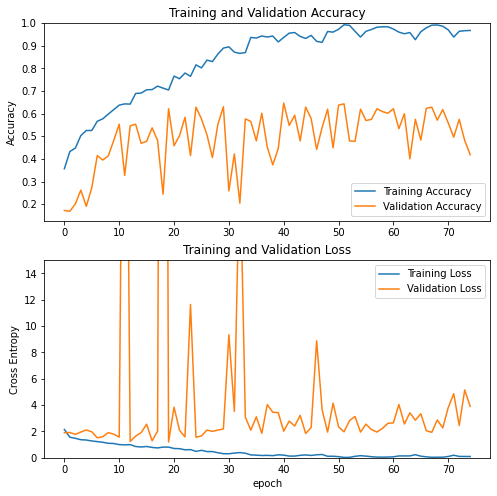

In [24]:
#plot the results along each epoch
acc = base_res_net_history.history['acc']
val_acc = base_res_net_history.history['val_acc']

loss = base_res_net_history.history['loss']
val_loss = base_res_net_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,15])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Picking the best looking model saved from the callback
I am picking the model at epoch 20 because it has a validation accuracy close to 62%, which is not too much lower than the training accuracy of 70% for that epoch. Also, the validation accuracy doesn't get much higher than 62% throughout training, while the training accuracy continues to increase. Picking a model with more epochs of training may have more overfitting. In the next step, I will be applying data augmentation to the training, so hopefully that will shrink the gap between the training and validation accuracy and lower the danger of overfitting too. Overall though, the validation accuracy seems highly variable, so I'm a little concerned.

In [26]:
trained_res_net_model = keras.models.load_model('/content/resnet_models/base_res_net_model12.7.20-1.20.h5')

In [27]:
trained_res_net_model.save('/content/gdrive/MyDrive/ResNetScratch12.7.h5')

In [28]:
#now to delete the models not used since the chosen one has been saved to my google drive
filelist = [ f for f in os.listdir('/content/resnet_models/') if f.endswith(".h5") ]
for f in filelist:
    os.remove(os.path.join('/content/resnet_models/', f))

### Applying Data Augmentation to the training

In [29]:
train_datagen_aug = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.15,
      height_shift_range=0.15,
      shear_range=0.15,
      zoom_range=0.2,
      horizontal_flip=True)

In [30]:
train_generator_aug = train_datagen_aug.flow_from_directory(
        train_dir,
        target_size=(250, 187),
        batch_size=20,
        class_mode='categorical')

Found 1108 images belonging to 6 classes.


In [31]:
my_callbacks_aug = [
    tf.keras.callbacks.ModelCheckpoint(filepath='/content/resnet_models/base_aug_res_net_model12.7.{epoch:02d}-{val_loss:.2f}.h5'),
]

In [32]:
history_aug = trained_res_net_model.fit(
      train_generator_aug,
      epochs=45,
      validation_data=validation_generator,
      callbacks=my_callbacks_aug)

Epoch 1/45
56/56 [==============================] - 15s 260ms/step - loss: 0.9662 - acc: 0.6300 - val_loss: 3.8461 - val_acc: 0.4381
Epoch 2/45
56/56 [==============================] - 14s 245ms/step - loss: 0.9609 - acc: 0.6579 - val_loss: 2.0246 - val_acc: 0.4309
Epoch 3/45
56/56 [==============================] - 14s 244ms/step - loss: 0.9882 - acc: 0.6381 - val_loss: 10.3223 - val_acc: 0.3250
Epoch 4/45
56/56 [==============================] - 14s 243ms/step - loss: 0.9569 - acc: 0.6543 - val_loss: 1.5824 - val_acc: 0.5440
Epoch 5/45
56/56 [==============================] - 14s 253ms/step - loss: 1.0007 - acc: 0.6480 - val_loss: 18.2765 - val_acc: 0.1544
Epoch 6/45
56/56 [==============================] - 14s 250ms/step - loss: 0.9552 - acc: 0.6561 - val_loss: 4.5890 - val_acc: 0.3573
Epoch 7/45
56/56 [==============================] - 14s 251ms/step - loss: 0.8761 - acc: 0.6841 - val_loss: 0.9288 - val_acc: 0.6804
Epoch 8/45
56/56 [==============================] - 14s 248ms/step 

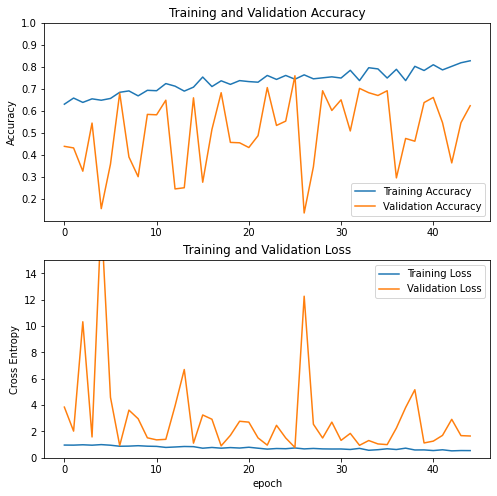

In [34]:
#now to visualize these results along each epoch
acc_aug = history_aug.history['acc']
val_acc_aug = history_aug.history['val_acc']

loss_aug = history_aug.history['loss']
val_loss_aug = history_aug.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_aug, label='Training Accuracy')
plt.plot(val_acc_aug, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_aug, label='Training Loss')
plt.plot(val_loss_aug, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,15])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Picking a model from the callbacks based on the epoch performances above
The model at epoch 26 has good validation accuracy of 76%, which is slightly higher than the training accuracy of 74%. I am choosing this model because the validation and training accuracies are close to each other, and after this point, the validation accuracy appears to start declining overall. Again, the validation accuracy is very volatile, which is concerning.

In [35]:
end_model = keras.models.load_model('/content/resnet_models/base_aug_res_net_model12.7.26-0.78.h5')

In [36]:
end_model.save('/content/gdrive/MyDrive/ResNetScratch_aug12.7.h5')

In [37]:
#now to delete the unneeded files again to free up storage
filelist = [ f for f in os.listdir('/content/resnet_models/') if f.endswith(".h5") ]
for f in filelist:
    os.remove(os.path.join('/content/resnet_models/', f))

### Remarks
Overall, the acheived training and validation accuracies are pretty decent. The validation accuracy has peaked at "76%". However, this is very low when considering the severity of a misclassification. Also, the validation accuracy has been very volatile, so I'm not confident that this model will generalize well to test data. I think that I will need to explore transfer learning from pretrained models to acheive better results.

# Transfer Learning Using Pretrained Models
### In particular, I will be looking at ResNet50, Xception, and MobileNetV2 and then comparing the results after training top layers in order to choose the best model for this data before fine-tuning some of the core layers.

First of all, these models have been fit to perform on images standardized in a specific way. Therefore I will create two new data generators (training and validation) that don't apply any scaling. The training generator will also have data augmentation applied to it.

Second, in order to compare the results from the model, the input shapes need to be the same across all models. Since MobileNet V2 needs the input shape to be square and divisible by 32, I will feed images of shape [192,192,3] into all the models.

In [38]:
train_datagen_aug_no_scale = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.15,
      height_shift_range=0.15,
      shear_range=0.15,
      zoom_range=0.2,
      horizontal_flip=True)
train_generator_aug_no_scale = train_datagen_aug_no_scale.flow_from_directory(
        train_dir,
        target_size=(192, 192),
        batch_size=32,
        class_mode='categorical')


test_datagen_noscale = ImageDataGenerator()

validation_generator_noscale = test_datagen_noscale.flow_from_dataframe(
        validation_info_df,
        target_size=(192, 192),
        batch_size=32,
        x_col = 'File Locations',
        y_col = 'File Label',
        class_mode='categorical')

Found 1108 images belonging to 6 classes.
Found 557 validated image filenames belonging to 6 classes.


## ResNet50 CNN Using pretrained weights

In [266]:
#creating the input layer
inputs = tf.keras.layers.Input(shape=(192, 192, 3))
#put the inputs through the preprocessing layer to get the images scaled/standardized accordingly
x = tf.keras.applications.resnet50.preprocess_input(inputs)
#get the resnet core (not the top classification layer)
core = keras.applications.ResNet50(
    weights='imagenet', 
    input_shape=(192, 192, 3),
    include_top=False
)
#set it to be non trainable
core.trainable = False
#adding the core layers on top of the input/preprocessing layers
x = core(x,training=False)
#add the global average pooling on top
x = keras.layers.GlobalAveragePooling2D()(x)
#I found that I got better results when adding an additional dense layer after the 
#global average pulling and then adding a drop out followed by batch normalization
x = keras.layers.Dense(1024,activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
#x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(512,activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
#x = keras.layers.Dense(256,activation='relu')(x)
#x = keras.layers.Dropout(0.5)(x)
x = keras.layers.BatchNormalization()(x)
#lastly, the top dense classification layer needs to be added
outputs = keras.layers.Dense(len(mushroom_species),activation='softmax')(x)
#put it all together
model = keras.Model(inputs, outputs)

In [267]:
model.summary()

Model: "functional_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        [(None, 192, 192, 3)]     0         
_________________________________________________________________
tf_op_layer_strided_slice_18 [(None, 192, 192, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd_18 (Tens [(None, 192, 192, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 6, 6, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_25  (None, 2048)              0         
_________________________________________________________________
dense_63 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_39 (Dropout)         (None, 1024)            

In [140]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0003),
    loss = 'categorical_crossentropy',
    metrics = ['acc']
)

In [42]:
#making a directory for the models at each epoch to be saved to
!mkdir /content/pretrained_models

In [106]:
my_callbacks_pretrained = [
    tf.keras.callbacks.ModelCheckpoint(filepath='/content/pretrained_models/base_pretrained_model12.7.{epoch:02d}-{val_loss:.2f}.h5')
]

In [141]:
epochs = 25
pretrained_resnet_history2 = model.fit(train_generator_aug_no_scale, epochs=epochs, validation_data=validation_generator_noscale,callbacks=my_callbacks_pretrained)

Epoch 1/25
35/35 [==============================] - 11s 314ms/step - loss: 1.7799 - acc: 0.3475 - val_loss: 0.7914 - val_acc: 0.7558
Epoch 2/25
35/35 [==============================] - 10s 291ms/step - loss: 1.1170 - acc: 0.6029 - val_loss: 0.5610 - val_acc: 0.8151
Epoch 3/25
35/35 [==============================] - 10s 291ms/step - loss: 0.9255 - acc: 0.6787 - val_loss: 0.4789 - val_acc: 0.8294
Epoch 4/25
35/35 [==============================] - 10s 295ms/step - loss: 0.7215 - acc: 0.7554 - val_loss: 0.4583 - val_acc: 0.8474
Epoch 5/25
35/35 [==============================] - 10s 293ms/step - loss: 0.6535 - acc: 0.7744 - val_loss: 0.4632 - val_acc: 0.8438
Epoch 6/25
35/35 [==============================] - 10s 297ms/step - loss: 0.5952 - acc: 0.7870 - val_loss: 0.4074 - val_acc: 0.8546
Epoch 7/25
35/35 [==============================] - 10s 294ms/step - loss: 0.5356 - acc: 0.8105 - val_loss: 0.3785 - val_acc: 0.8582
Epoch 8/25
35/35 [==============================] - 10s 293ms/step - 

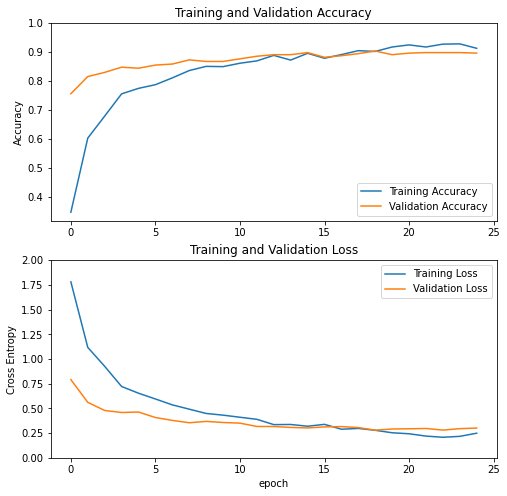

In [142]:
#visualize the results along each epoch
acc = pretrained_resnet_history2.history['acc']
val_acc = pretrained_resnet_history2.history['val_acc']

loss = pretrained_resnet_history2.history['loss']
val_loss = pretrained_resnet_history2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Picking the best looking model saved from the callback
I am picking the model at epoch 19 because this is where the training accuracy overcomes the validation accuracy and the validation accuracy doesn't substantially increase after this point. At this epoch, the validation accuracy is 90.3% and the training accuracy is 90.1%.

In [143]:
trained_res_net_model_deep = keras.models.load_model('/content/pretrained_models/base_pretrained_model12.7.19-0.28.h5')

In [144]:
trained_res_net_model_deep.save('/content/gdrive/MyDrive/ResNetPretrained_deep12.7.h5')

In [145]:
#delete the unneeded models saved from the callbacks
filelist = [ f for f in os.listdir('/content/pretrained_models/') if f.endswith(".h5") ]
for f in filelist:
    os.remove(os.path.join('/content/pretrained_models/', f))

## Xception CNN Using pretrained weights

In [149]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(192, 192, 3),
    include_top=False,
)  
# Freeze the base_model
base_model.trainable = False

# Create an input layer
inputs = keras.Input(shape=(192, 192, 3))
#add a preprocessing layer on top of the input layer so that the images are scaled/standardized accordingly
x = keras.applications.xception.preprocess_input(inputs)

# feed the processed image layers into the base model while keeping the layers frozen
x = base_model(x, training=False)
#adding the global average pooling layer
x = keras.layers.GlobalAveragePooling2D()(x)
#I found that adding in an additional dense layer with a relu activation function and
#a batch normalization layers helps the model performance
x = keras.layers.Dense(1024,activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(512,activation='relu')(x)
#adding a dropout layer to help regularize
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.BatchNormalization()(x)
#Lastly, add the top dense classification layer
outputs = keras.layers.Dense(len(mushroom_species),activation='softmax')(x)
#put it all together
model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_47 (InputLayer)        [(None, 192, 192, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_4 (Tenso [(None, 192, 192, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_4 (TensorFlo [(None, 192, 192, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 6, 6, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_22  (None, 2048)              0         
_________________________________________________________________
dense_56 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_35 (Dropout)         (None, 1024)            

In [150]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0003),
    loss = 'categorical_crossentropy',
    metrics = ['acc']
)

In [151]:
epochs = 50
pretrained_xception_history = model.fit(train_generator_aug_no_scale, epochs=epochs, validation_data=validation_generator_noscale,callbacks=my_callbacks_pretrained)

Epoch 1/50
35/35 [==============================] - 11s 311ms/step - loss: 1.7910 - acc: 0.3791 - val_loss: 0.8203 - val_acc: 0.7630
Epoch 2/50
35/35 [==============================] - 10s 297ms/step - loss: 1.1271 - acc: 0.6038 - val_loss: 0.6672 - val_acc: 0.7738
Epoch 3/50
35/35 [==============================] - 10s 296ms/step - loss: 0.9735 - acc: 0.6679 - val_loss: 0.5761 - val_acc: 0.8043
Epoch 4/50
35/35 [==============================] - 11s 302ms/step - loss: 0.8705 - acc: 0.7031 - val_loss: 0.5375 - val_acc: 0.8259
Epoch 5/50
35/35 [==============================] - 10s 297ms/step - loss: 0.7756 - acc: 0.7211 - val_loss: 0.4988 - val_acc: 0.8259
Epoch 6/50
35/35 [==============================] - 10s 296ms/step - loss: 0.7284 - acc: 0.7464 - val_loss: 0.4913 - val_acc: 0.8241
Epoch 7/50
35/35 [==============================] - 10s 296ms/step - loss: 0.6617 - acc: 0.7744 - val_loss: 0.5259 - val_acc: 0.8133
Epoch 8/50
35/35 [==============================] - 10s 300ms/step - 

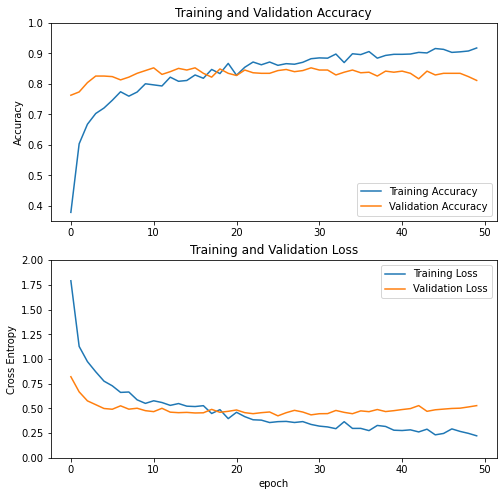

In [152]:
#visualize the results along each epoch
acc = pretrained_xception_history.history['acc']
val_acc = pretrained_xception_history.history['val_acc']

loss = pretrained_xception_history.history['loss']
val_loss = pretrained_xception_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Picking the best looking model saved from the callback
I am picking the model at epoch 19 because this is approximately where the training accuracy overcomes the validation accuracy and further training doesn't increase the validation accuracy. At this epoch, the validation accuracy is 85% and the training accuracy is 83%.

In [153]:
trained_xception_model_deep = keras.models.load_model('/content/pretrained_models/base_pretrained_model12.7.19-0.46.h5')

In [154]:
trained_xception_model_deep.save('/content/gdrive/MyDrive/XceptionPretrained_deep12.7.h5')

In [155]:
#delete the unneeded models saved from the callbacks
filelist = [ f for f in os.listdir('/content/pretrained_models/') if f.endswith(".h5") ]
for f in filelist:
    os.remove(os.path.join('/content/pretrained_models/', f))

## MobileNet V2 CNN Using pretrained weights

In [157]:
base_model = keras.applications.MobileNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(192, 192, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create input layer for the model
inputs = keras.Input(shape=(192, 192, 3))
#add a preprocessing layer to get the image data into the correct scaling/standardization
x = keras.applications.mobilenet_v2.preprocess_input(inputs)

#feed the preprocessed images into the base models layers
x = base_model(x, training=False)
#add on a global average pooling layer
x = keras.layers.GlobalAveragePooling2D()(x)
#i found that adding an additional dense layer and then doing drop out followed by a batchnormalization gives better results than only doing a dense classification layer
x = keras.layers.Dense(1024,activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(512,activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.BatchNormalization()(x)
#add on the dense classification layer
outputs = keras.layers.Dense(len(mushroom_species),activation='softmax')(x)
#put it all together
model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        [(None, 192, 192, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_6 (Tenso [(None, 192, 192, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_6 (TensorFlo [(None, 192, 192, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_192 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_24  (None, 1280)              0         
_________________________________________________________________
dense_60 (Dense)             (None, 1024)              1311744   
_________________________________________________________________
dropout_37 (Dropout)         (None, 1024)            

In [158]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0003),
    loss = 'categorical_crossentropy',
    metrics = ['acc']
)

In [159]:
epochs = 50
pretrained_mobilenet_history_deep = model.fit(train_generator_aug_no_scale, epochs=epochs, validation_data=validation_generator_noscale,callbacks=my_callbacks_pretrained)

Epoch 1/50
35/35 [==============================] - 11s 304ms/step - loss: 1.8242 - acc: 0.3484 - val_loss: 0.8367 - val_acc: 0.7540
Epoch 2/50
35/35 [==============================] - 10s 284ms/step - loss: 1.1133 - acc: 0.6146 - val_loss: 0.6260 - val_acc: 0.7899
Epoch 3/50
35/35 [==============================] - 10s 285ms/step - loss: 0.8532 - acc: 0.7103 - val_loss: 0.5272 - val_acc: 0.8205
Epoch 4/50
35/35 [==============================] - 11s 318ms/step - loss: 0.7738 - acc: 0.7310 - val_loss: 0.5129 - val_acc: 0.8151
Epoch 5/50
35/35 [==============================] - 10s 288ms/step - loss: 0.6579 - acc: 0.7708 - val_loss: 0.4877 - val_acc: 0.8115
Epoch 6/50
35/35 [==============================] - 10s 281ms/step - loss: 0.6378 - acc: 0.7870 - val_loss: 0.4765 - val_acc: 0.8312
Epoch 7/50
35/35 [==============================] - 10s 282ms/step - loss: 0.5797 - acc: 0.8032 - val_loss: 0.4512 - val_acc: 0.8510
Epoch 8/50
35/35 [==============================] - 10s 282ms/step - 

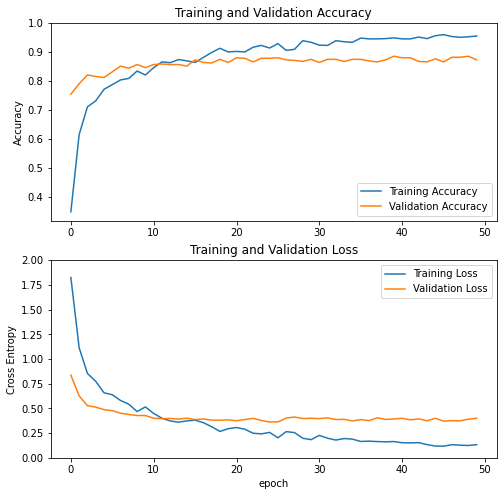

In [161]:
#visualize the results along each epoch
acc = pretrained_mobilenet_history_deep.history['acc']
val_acc = pretrained_mobilenet_history_deep.history['val_acc']

loss = pretrained_mobilenet_history_deep.history['loss']
val_loss = pretrained_mobilenet_history_deep.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Picking the best looking model saved from the callback
I am picking the model at epoch 16 because this is where the training accuracy overcomes the validation accuracy. After this point, the validation accuracy only increases slightly. Choosing a model at a later epoch may increase the risk of a model too specialized on the training data, and may not generalize well to new images.

In [162]:
trained_mobilenet_model_deep = keras.models.load_model('/content/pretrained_models/base_pretrained_model12.7.16-0.39.h5')

In [163]:
trained_mobilenet_model_deep.save('/content/gdrive/MyDrive/MobileNetPretrained_deep12.7.h5')

In [72]:
#delete the unneeded models saved from the callbacks
filelist = [ f for f in os.listdir('/content/pretrained_models/') if f.endswith(".h5") ]
for f in filelist:
    os.remove(os.path.join('/content/pretrained_models/', f))

## Comparison of Pretrained Models with data specific tops

In [166]:
train_datagen_testing = ImageDataGenerator()
test_datagen_testing = ImageDataGenerator()

train_generator_testing = train_datagen_testing.flow_from_dataframe(
        train_info_df,
        target_size=(192, 192),
        batch_size=1108,
        x_col='File Locations',
        y_col = 'File Label',
        seed = 112720,
        class_mode='categorical')


validation_generator_testing = test_datagen_testing.flow_from_dataframe(
        validation_info_df,
        target_size=(192, 192),
        batch_size=557,
        x_col = 'File Locations',
        y_col = 'File Label',
        seed=112720,
        class_mode='categorical')

Found 1108 validated image filenames belonging to 6 classes.
Found 557 validated image filenames belonging to 6 classes.


In [167]:
resnet_results = trained_res_net_model_deep.evaluate(train_generator_testing[0][0],train_generator_testing[0][1],batch_size=32)
resnet_validation = trained_res_net_model_deep.evaluate(validation_generator_testing[0][0],validation_generator_testing[0][1],batch_size=32)

xception_results = trained_xception_model_deep.evaluate(train_generator_testing[0][0],train_generator_testing[0][1],batch_size=32)
xception_validation = trained_xception_model_deep.evaluate(validation_generator_testing[0][0],validation_generator_testing[0][1],batch_size=32)

mobilenet_results = trained_mobilenet_model_deep.evaluate(train_generator_testing[0][0],train_generator_testing[0][1],batch_size=32)
mobilenet_validation = trained_mobilenet_model_deep.evaluate(validation_generator_testing[0][0],validation_generator_testing[0][1],batch_size=32)

18/18 [==============================] - 0s 21ms/step - loss: 0.3871 - acc: 0.8725


In [168]:
output_df = pd.DataFrame({'Model':['ResNet50','Xception','MobileNet V2'],'Training Accuracy':[resnet_results[1],xception_results[1],mobilenet_results[1]],
                          'Validation Accuracy':[resnet_validation[1],xception_validation[1],mobilenet_validation[1]]})

In [169]:
output_df

,Model,Training Accuracy,Validation Accuracy
0,ResNet50,0.968412,0.903052
1,Xception,0.898917,0.849192
2,MobileNet V2,0.958484,0.872531


#### Remarks
The training accuracies are higher than seen in the epoch training graphs above. This must be because the training accuracies shown at each epoch are the average training accuracy across the batches. However, what is being shown here is the accuracy at the end of the training on all 35 batches. Also, the training accuracies acheived during training are lower because they had augmented training data. Between the three of the models, the ResNet50 model appears the best. I will go forward using this model and then do some fine tuning in attempts of further increasing the accuracy.

## Fine Tuning

First I want to start out by only unfreezing the top 10 layers of the core ResNet50 layers.

In [374]:
top_layer_trained_model = keras.models.load_model('/content/gdrive/MyDrive/ResNetPretrained_deep12.7.h5')

In [186]:
#showing how many layers are in the resnet50 core architecture
len(top_layer_trained_model.layers[3].layers)

175

In [375]:
for layer in top_layer_trained_model.layers[3].layers[100:]:
  layer.trainable = True

In [376]:
top_layer_trained_model.summary()

Model: "functional_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        [(None, 192, 192, 3)]     0         
_________________________________________________________________
tf_op_layer_strided_slice_17 (None, 192, 192, 3)       0         
_________________________________________________________________
tf_op_layer_BiasAdd_17 (Tens (None, 192, 192, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 6, 6, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_20  (None, 2048)              0         
_________________________________________________________________
dense_50 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_31 (Dropout)         (None, 1024)            

In [377]:
top_layer_trained_model.compile(
    optimizer=keras.optimizers.Adam(.000003),
    loss = 'categorical_crossentropy',
    metrics = ['acc']
)

In [378]:
epochs = 50
fine_tuning_resnet_history = top_layer_trained_model.fit(train_generator_aug_no_scale, epochs=epochs, validation_data=validation_generator_noscale,callbacks = my_callbacks_pretrained)

Epoch 1/50
35/35 [==============================] - 12s 339ms/step - loss: 0.2443 - acc: 0.9143 - val_loss: 0.2694 - val_acc: 0.8977
Epoch 2/50
35/35 [==============================] - 11s 316ms/step - loss: 0.2299 - acc: 0.9152 - val_loss: 0.2630 - val_acc: 0.9048
Epoch 3/50
35/35 [==============================] - 11s 322ms/step - loss: 0.2302 - acc: 0.9278 - val_loss: 0.2574 - val_acc: 0.9066
Epoch 4/50
35/35 [==============================] - 11s 314ms/step - loss: 0.1783 - acc: 0.9395 - val_loss: 0.2555 - val_acc: 0.9102
Epoch 5/50
35/35 [==============================] - 11s 311ms/step - loss: 0.1750 - acc: 0.9431 - val_loss: 0.2579 - val_acc: 0.9120
Epoch 6/50
35/35 [==============================] - 11s 314ms/step - loss: 0.1726 - acc: 0.9395 - val_loss: 0.2569 - val_acc: 0.9031
Epoch 7/50
35/35 [==============================] - 11s 311ms/step - loss: 0.1540 - acc: 0.9522 - val_loss: 0.2477 - val_acc: 0.9120
Epoch 8/50
35/35 [==============================] - 11s 312ms/step - 

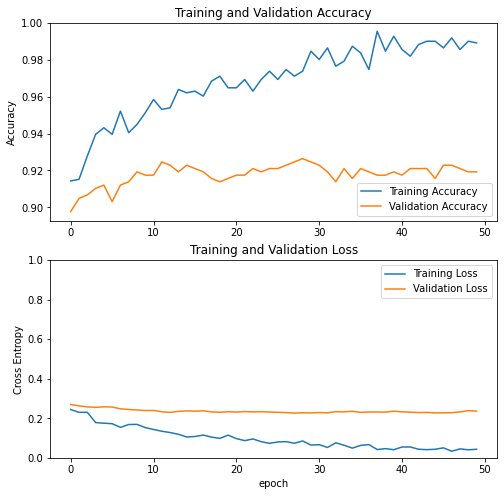

In [379]:
#visualize the results along each epoch
acc = fine_tuning_resnet_history.history['acc']
val_acc = fine_tuning_resnet_history.history['val_acc']

loss = fine_tuning_resnet_history.history['loss']
val_loss = fine_tuning_resnet_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Picking the best looking model saved from the callback
I am picking the model at epoch 12 because at this point, the validation accuracy actually starts to decline a little bit, and the training accuracy still increases. This is telling me that any further fine tuning is only increasing the models ability to classify the training images, and no longer has a positive impact on performance on new images. At epoch 12, the validation accuracy is 92.5% and the training accuracy is 95%.

In [383]:
fine_tuned_res_net_model = keras.models.load_model('/content/pretrained_models/base_pretrained_model12.7.12-0.23.h5')

In [384]:
fine_tuned_res_net_model.save('/content/gdrive/MyDrive/ResNetFineTuned12.7.h5')

In [385]:
#delete the unneeded models saved from the callbacks
filelist = [ f for f in os.listdir('/content/pretrained_models/') if f.endswith(".h5") ]
for f in filelist:
    os.remove(os.path.join('/content/pretrained_models/', f))

# Evaluate the Final Model

In [386]:
#first, I need to set up the test data generator
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
        test_info_df,
        target_size=(192, 192),
        batch_size=32,
        x_col = 'File Locations',
        y_col = 'File Label',
        seed=112720,
        class_mode='categorical')

Found 419 validated image filenames belonging to 6 classes.


In [387]:
#generate and record the predictions
images = []
predictions = []
labels = []
for i in range(len(test_generator)):
  batch_predictions = fine_tuned_res_net_model.predict(test_generator[i][0])
  predictions += list(batch_predictions)
  labels += list(test_generator[i][1])
  images += list(test_generator[i][0])

Model predicted test images with 0.931 accuracy.


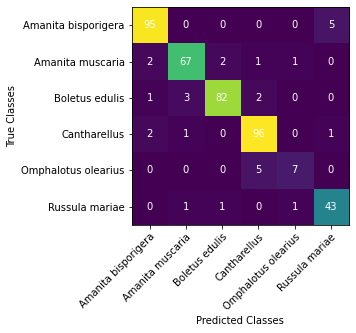

In [388]:
#getting predictions into confusion matrix
predictions_labels = [np.argmax(x) for x in predictions]
true_labels = [np.argmax(x) for x in labels]
probs = [max(x) for x in predictions]

matches = [predictions_labels[i]==true_labels[i] for i in range(len(predictions_labels))]
matches_numeric = list(np.array(matches).astype('int32'))

print('Model predicted test images with '+"%0.3f"%(sum(matches_numeric)/len(matches_numeric))+' accuracy.')

fig,ax=plt.subplots()
ax.imshow(confusion_matrix(true_labels,predictions_labels))
ax.set_xticks(range(len(mushroom_species)))
ax.set_xticklabels(mushroom_species)
ax.set_yticks(range(len(mushroom_species)))
ax.set_yticklabels(mushroom_species)
ax.set_xlabel('Predicted Classes')
ax.set_ylabel('True Classes')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(len(mushroom_species)):
    for j in range(len(mushroom_species)):
        text = ax.text(j, i, confusion_matrix(true_labels,predictions_labels)[i, j],
                       ha="center", va="center", color="w") 

### Show what the Best Predictions look like

In [389]:
#show what the best prediction images look like
pred_df = pd.DataFrame({'Label':true_labels,'Probs':probs})
pred_df

,Label,Probs
0,0,0.977926
1,5,0.999926
2,3,0.997190
3,0,0.999607
4,1,0.999946
...,...,...
414,2,0.996012
415,1,0.715951
416,0,0.996893
417,0,0.996052


In [390]:
#sorting the dataframe by its probabilities
best_9_indices = pred_df.copy().sort_values(by='Probs',ascending=False).index[:9]

In [391]:
#only grabbing information for the 9 best predictions (highest prediction probabilities)
best_9_labels = pred_df['Label'][best_9_indices]
best_9_images = []
for i in list(best_9_indices):
  best_9_images.append(images[i])

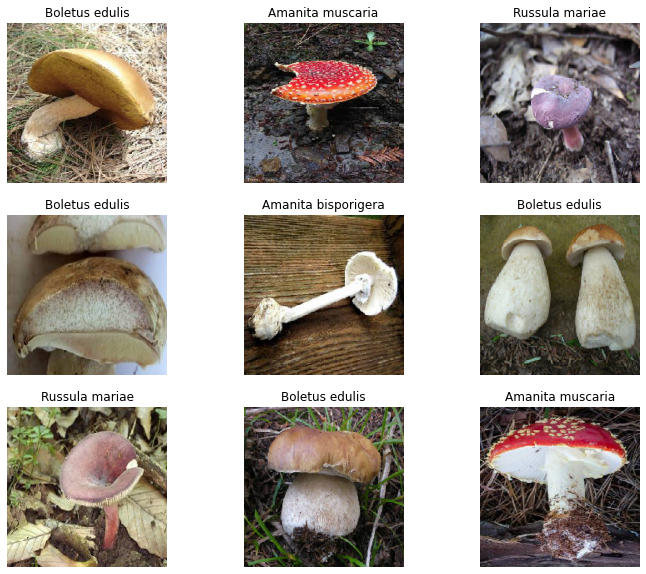

In [392]:
#plotting the 9 best predictions
plt.figure(figsize=(12,10))

for i, img in enumerate(best_9_images):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(img*1/255)
  plt.title(mushroom_species[list(best_9_labels)[i]])
  plt.axis('off')

Something all of these images have in common is that they show both the stem and head of the mushroom and the mushroom is the main focus of the image.

### Show what the worst predictions look like

In [393]:
#show what the worst prediction images look like
worst_9_indices = pred_df.copy().sort_values(by='Probs').index[:9]

In [394]:
#only grabbing information for the 9 worst predictions
worst_9_labels = pred_df['Label'][worst_9_indices]
worst_9_images = []
for i in list(worst_9_indices):
  worst_9_images.append(images[i])

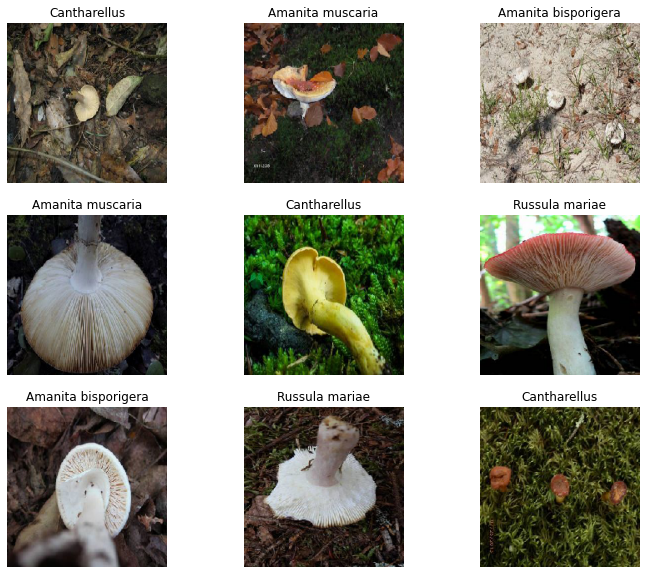

In [395]:
#plotting the 9 worst predictions
plt.figure(figsize=(12,10))

for i, img in enumerate(worst_9_images):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(img*1/255)
  plt.title(mushroom_species[list(worst_9_labels)[i]])
  plt.axis('off')

Something these images have in common is that 4 of them don't show the top of the mushroom. Two of the images have mushrooms that are far away from the camera. One of the pictures shows what looks like a rotten mushroom.

Model predicted test images with 0.961 accuracy.
Total of 383 images out of 419 total test images.


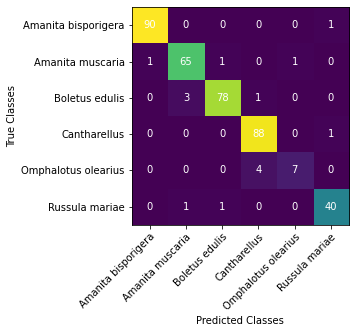

In [396]:
#now let's see if using a cutoff of 0.75 in order to classify an image (rather than just taking the highest probability and assigning)
#if all the probabilities are less than 0.75, then classify as 'non-classifyable'
predictions_labels = []
true_labels = []
probs = []
for i, x in enumerate(predictions):
  if max(x) >= 0.75:
    predictions_labels.append(np.argmax(x))
    true_labels.append(np.argmax(labels[i]))
    probs.append(max(x))

matches = [predictions_labels[i]==true_labels[i] for i in range(len(predictions_labels))]
matches_numeric = list(np.array(matches).astype('int32'))

print('Model predicted test images with '+"%0.3f"%(sum(matches_numeric)/len(matches_numeric))+' accuracy.')
print('Total of '+str(len(predictions_labels))+' images out of '+str(len(predictions))+' total test images.')
fig,ax=plt.subplots()
ax.imshow(confusion_matrix(true_labels,predictions_labels))
ax.set_xticks(range(len(mushroom_species)))
ax.set_xticklabels(mushroom_species)
ax.set_yticks(range(len(mushroom_species)))
ax.set_yticklabels(mushroom_species)
ax.set_xlabel('Predicted Classes')
ax.set_ylabel('True Classes')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(len(mushroom_species)):
    for j in range(len(mushroom_species)):
        text = ax.text(j, i, confusion_matrix(true_labels,predictions_labels)[i, j],
                       ha="center", va="center", color="w") 

It looks like adding the extra step of requiring an image to have atleast a 75% probability for the class it is assigned to really helped out. It increased the accuracy in the test image set by 3%! However, in this test set, 8.6% of the mushrooms were determined as 'not classified', which in this projects context would mean getting thrown out.

It looks like the model has a hard time distinguishing between Cantharellus and its poisonous look-a-like Omphalotus olearius. Also, there is 1 poisonous Amanita Bisporigera that was misclassified as an edible Russula Mariae. Lastly, there are other misclassifications, but no more that misclassified a poisonous mushroom as edible. It is good to see that not a single mushroom classified as Amanita Muscaria was actually it's deadly look-a-like Amanita Bisporigera. 